In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.signal import ShortTimeFFT, get_window

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
model = torch.load(
    "/scratch/gpfs/nc1514/TokEye/model/big_mode_v1.pt",
    weights_only=False,
    )
model.to(device)
model.eval()
print("Model loaded")

Model loaded


In [5]:
shotn = "153677"

In [6]:
root_path = Path("/scratch/gpfs/nc1514/TokEye/data/eval/D3D2025")
raw_path = root_path / shotn / "raw"
spec_path = root_path / shotn / "spec"

In [7]:
SFT = ShortTimeFFT(
    win=get_window("hann", 1024),
    hop=512,
    fs=500,
)


In [8]:
signal_name = "co2_density_r0.npy"
signal_path = raw_path / signal_name

In [9]:
# Load signal
signal_path = raw_path / signal_name
signal = np.load(signal_path)
signal = SFT.stft(signal)
signal = np.abs(signal)**2
signal = np.log1p(signal)

vmin, vmax = np.percentile(signal, (1, 99))
signal = np.clip(signal, vmin, vmax)

signal = signal[1:]

In [ ]:
# Model inference
signal_tensor = torch.from_numpy(signal).to(device)
signal_tensor = signal_tensor.unsqueeze(0).unsqueeze(0).float()
signal_tensor = (signal_tensor - signal_tensor.mean()) / signal_tensor.std()
with torch.no_grad():
    output = model(signal_tensor)
    output = output[0]
output = output.squeeze(0)
output = torch.sigmoid(output)
output = output[0].cpu().numpy()
output[output < 0.25] = 0

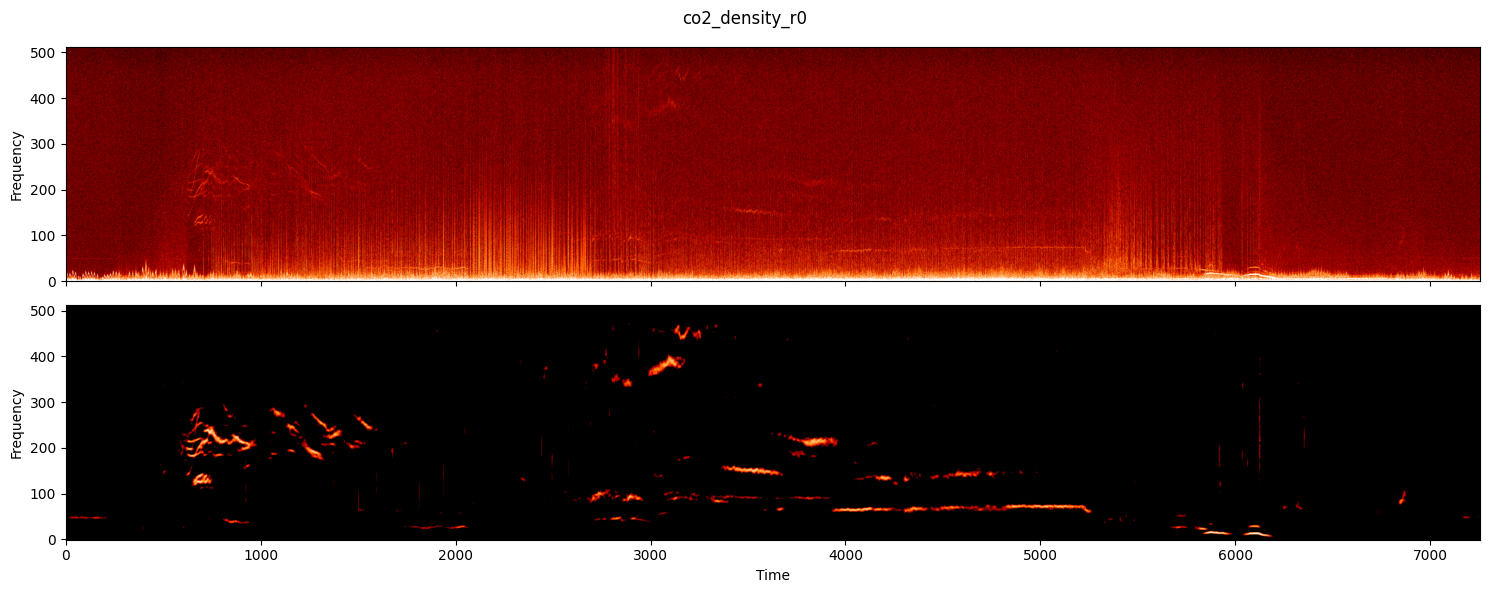

In [47]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(15, 6))

axes[0].imshow(signal, aspect='auto', origin='lower', cmap='gist_heat')
axes[0].set_ylabel('Frequency')

axes[1].imshow(output, aspect='auto', origin='lower', cmap='gist_heat', vmin=0, vmax=1)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Frequency')

plt.suptitle(f'{signal_path.stem}')

plt.tight_layout()
plt.show()